In [8]:
!pip install "numpy<2.0"

#!pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [15]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_dir = "/home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.11.2025 Interferogram"
out_dir = f'/home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.8.2025 Interferograms/FFT_Results'
os.makedirs(out_dir, exist_ok=True) # create output folder if doesn't already exist
print(f"Folder created or already exists: {out_dir}")


# # write outputs to a dedicated subfolder (safer) ---
# out_dir = img_dir / "normalized"
# out_dir.mkdir(exist_ok=True)

# Load background as 16-bit grayscale
bkgr_path = os.path.join(img_dir, "Background.tiff")
bkgr_array = load_gray16(bkgr_path).astype(np.int32)

Folder created or already exists: /home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.8.2025 Interferograms/FFT_Results


Saved normalized image: /home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.11.2025 Interferogram/norm_Gaussian Beam.tiff


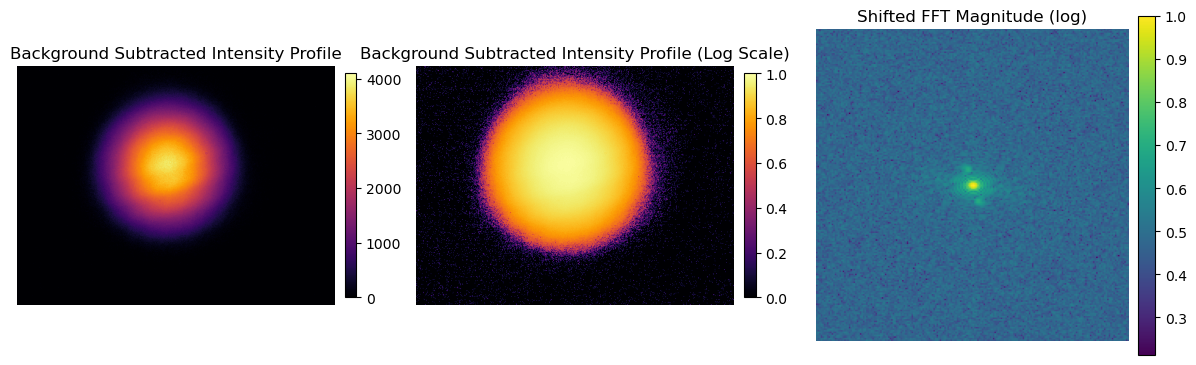

Saved normalized image: /home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.11.2025 Interferogram/norm_OAM L4 Hollow Core Interference.tiff


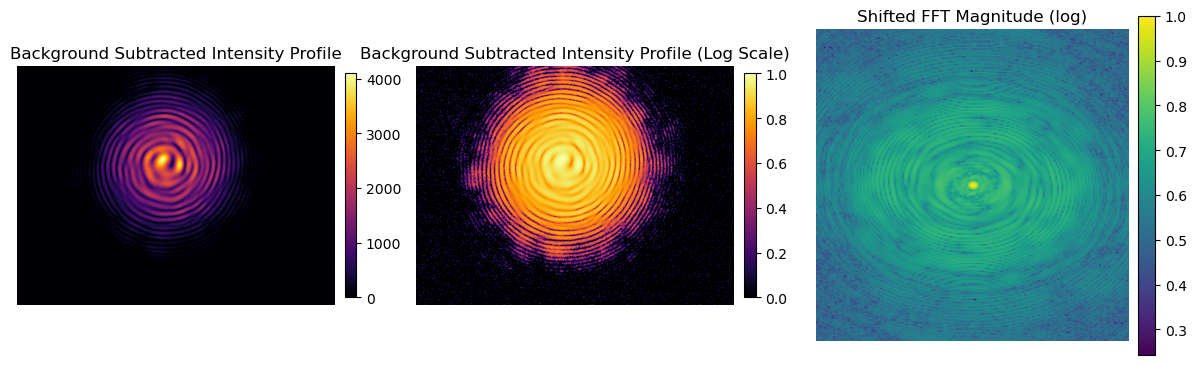

Saved normalized image: /home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.11.2025 Interferogram/norm_Gaussian Beam (Off Axis).tiff


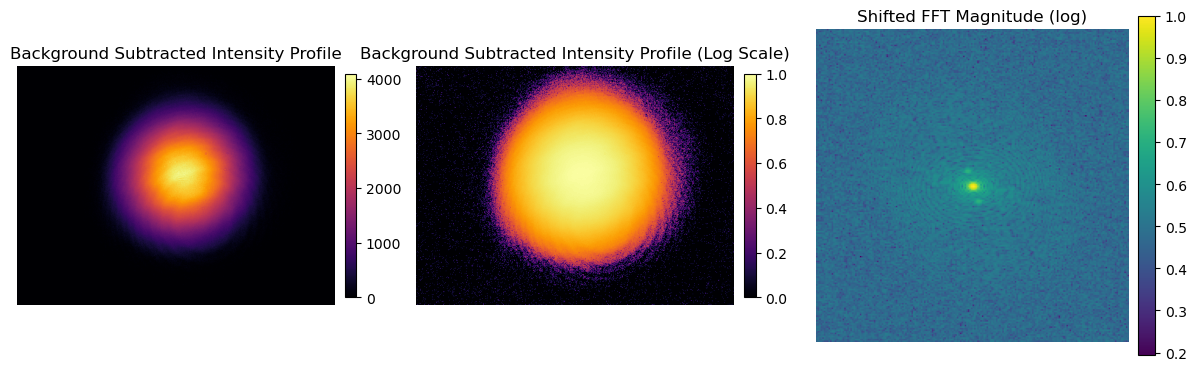

Saved normalized image: /home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.11.2025 Interferogram/norm_OAM L4 Hollow Core Interference (Off Axis).tiff


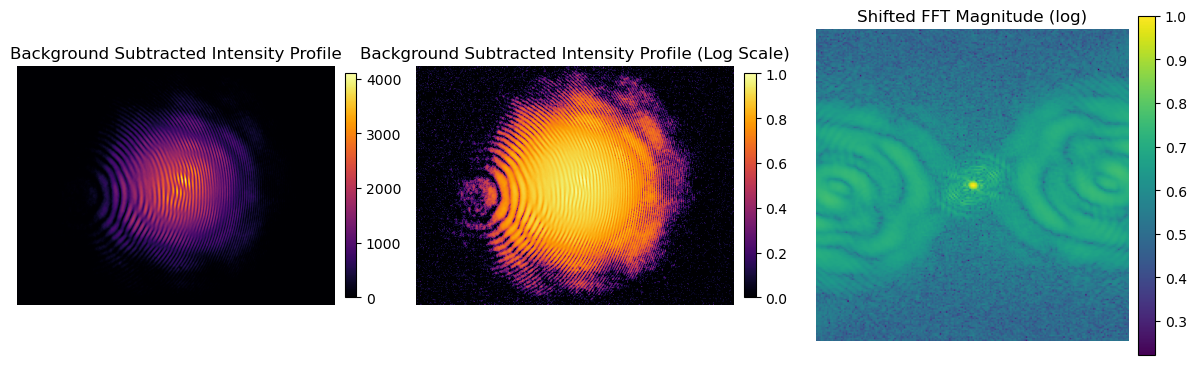

Saved normalized image: /home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.11.2025 Interferogram/norm_OAM L4 Hollow Core Coupled Beam (Off Axis).tiff


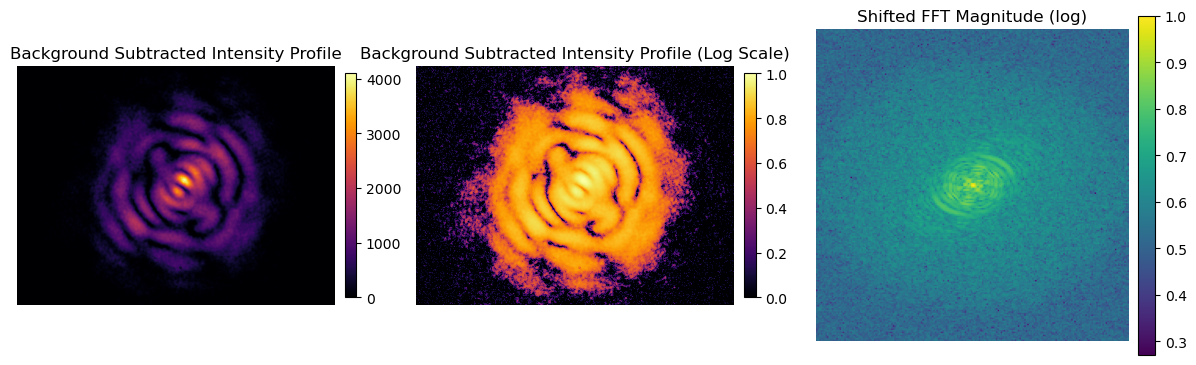

Saved normalized image: /home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.11.2025 Interferogram/norm_OAM L4 Hollow Core Coupled Beam.tiff


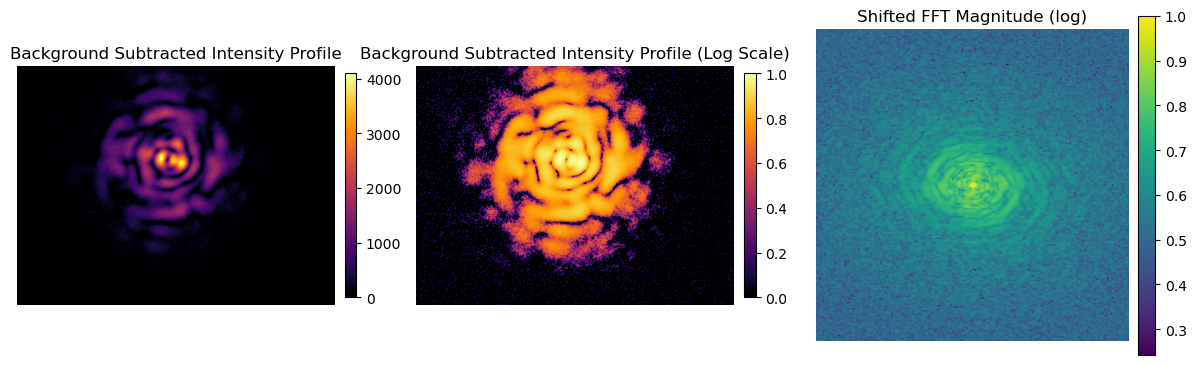

In [16]:

for filename in os.listdir(img_dir):
    # Skip the background file itself
    if "background" in filename.lower():
        continue

    # Skip non-TIFFs
    if not filename.lower().endswith((".tiff", ".tif")):
        continue

    # --- CRITICAL: skip files already normalized ---
    # Handles norm_, Norm_, etc.
    if filename.lower().startswith("norm_"):
        # Already-normalized artifact—skip
        continue

    # Build paths
    file_path = os.path.join(img_dir, filename)
    new_filename = "norm_" + filename
    # If using a subfolder, write there; otherwise, use img_dir
    output_path = os.path.join(img_dir, new_filename)

    # Load and process
    try:
        img_arr = load_gray16(str(file_path)).astype(np.int32)
    except Exception as e:
        print(f"Skipping {filename}: failed to load with error: {e}")
        continue

    # Ensure the image matches the background shape
    if img_arr.shape != bkgr_array.shape:
        print(f"Skipping {filename}: shape mismatch {img_arr.shape} vs {bkgr_array.shape}")
        continue

    # Background subtraction, clamp negatives
    norm_img = img_arr - bkgr_array
    np.maximum(norm_img, 0, out=norm_img)  # in-place clamp

    # Normalize to 0–4095 per-frame
    min_val = int(norm_img.min())
    max_val = int(norm_img.max())
    if max_val > min_val:
        norm_img = (4095.0 * (norm_img - min_val) / (max_val - min_val)).astype(np.uint16)
    else:
        norm_img = np.zeros_like(norm_img, dtype=np.uint16)

    # Save as 16-bit grayscale TIFF
    out = Image.fromarray(norm_img, mode="I;16")
    try:
        out.save(str(output_path))
        print(f"Saved normalized image: {output_path}")
    except Exception as e:
        print(f"Failed to save {new_filename}: {e}")

    # plot and FFT each normalized image
    img = plt.imread(output_path)
    fft_result = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft_result)
    log_mag = np.log(1 + np.abs(fft_shifted))
    log_mag_norm = (log_mag - log_mag.min()) / (log_mag.max() - log_mag.min())
    
    
    r = 100
    row_center = 540
    col_center = 720
    cropped_fft = log_mag_norm[row_center - r: row_center + r, col_center - r: col_center + r]
    
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    plt.title(filename)
    
    # Original Intensity Profile
    im0 = axs[0].imshow(img, cmap='inferno')
    axs[0].set_title("Background Subtracted Intensity Profile")
    axs[0].axis('off')  # Remove axis for cleaner look
    
    # Log Scale Intensity Profile
    enhanced_img = np.log1p(img)
    enhanced_img = enhanced_img / enhanced_img.max()
    im1 = axs[1].imshow(enhanced_img, cmap='inferno')
    axs[1].set_title("Background Subtracted Intensity Profile (Log Scale)")
    axs[1].axis('off')  # Remove axis for cleaner look
    
    # Shifted FFT Magnitude
    im2 = axs[2].imshow(cropped_fft, cmap='viridis')
    axs[2].set_title("Shifted FFT Magnitude (log)")
    axs[2].axis('off')  # Remove axis for cleaner look
    
    #Optional: Add colorbars
    fig.colorbar(im0, ax=axs[0], fraction=0.033, pad=0.03)
    fig.colorbar(im1, ax=axs[1], fraction=0.033, pad=0.03)
    fig.colorbar(im2, ax=axs[2], fraction=0.05, pad=0.03)
    
    plt.tight_layout()
    plt.show()
    
    


In [17]:
# out_dir = f'/home/c2eaefce-1e40-44c3-8824-0d44764c3b4c/Popmintchev Labs/Data/9.8.2025 Interferograms/FFT_Results'
# os.makedirs(out_dir, exist_ok=True) # create output folder if doesn't already exist
# print(f"Folder created or already exists: {out_dir}")

# img1 = os.path.join(img_dir, "norm_OAM L4 Hollow Core Coupled Beam (Off Axis).tiff")
# img2 = os.path.join(img_dir, "norm_OAM L4 Hollow Core Coupled Beam.tiff")
# img1 = plt.imread(img1)
# img2 = plt.imread(img2)

In [18]:
# print(type(OAM_Hollow_Int_Norm_1))
# print(OAM_Hollow_Int_Norm_1.shape)
# print(OAM_Hollow_Int_Norm_1.ndim)


In [19]:
# img_lst = [img1, img2]
# for img in img_lst:
#     fft_result = np.fft.fft2(img)
#     fft_shifted = np.fft.fftshift(fft_result)
#     log_mag = np.log(1 + np.abs(fft_shifted))
#     log_mag_norm = (log_mag - log_mag.min()) / (log_mag.max() - log_mag.min())
    
    
#     r = 100
#     row_center = 540
#     col_center = 720
#     cropped_fft = log_mag_norm[row_center - r: row_center + r, col_center - r: col_center + r]
    
    
#     fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
#     # Original Intensity Profile
#     im0 = axs[0].imshow(img, cmap='inferno')
#     axs[0].set_title("Background Subtracted Intensity Profile")
#     axs[0].axis('off')  # Remove axis for cleaner look
    
#     # Log Scale Intensity Profile
#     enhanced_img = np.log1p(img)
#     enhanced_img = enhanced_img / enhanced_img.max()
#     im1 = axs[1].imshow(enhanced_img, cmap='inferno')
#     axs[1].set_title("Background Subtracted Intensity Profile (Log Scale)")
#     axs[1].axis('off')  # Remove axis for cleaner look
    
#     # Shifted FFT Magnitude
#     im2 = axs[2].imshow(cropped_fft, cmap='viridis')
#     axs[2].set_title("Shifted FFT Magnitude (log)")
#     axs[2].axis('off')  # Remove axis for cleaner look
    
#     #Optional: Add colorbars
#     fig.colorbar(im0, ax=axs[0], fraction=0.033, pad=0.03)
#     fig.colorbar(im1, ax=axs[1], fraction=0.033, pad=0.03)
#     fig.colorbar(im2, ax=axs[2], fraction=0.05, pad=0.03)
    
    
#     plt.tight_layout()
#     plt.show()




In [20]:
# wrapped_first_order = np.angle(first_order_lobe)
# plt.figure(figsize=(6,6))
# plt.imshow(np.abs(All_Lobes ))
# plt.title("Magnitude")
# cbar = plt.colorbar()

